In [74]:
%pip install -r req.txt

Note: you may need to restart the kernel to use updated packages.


In [75]:
import matplotlib.pyplot as plt
import cv2
from facenet_pytorch import MTCNN, InceptionResnetV1 # face detector and face recognition
from PIL import Image # python imaging library
import torch.nn.functional

In [76]:
img_path = "images/group1.jpg"
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Face Detection with MTCNN
---

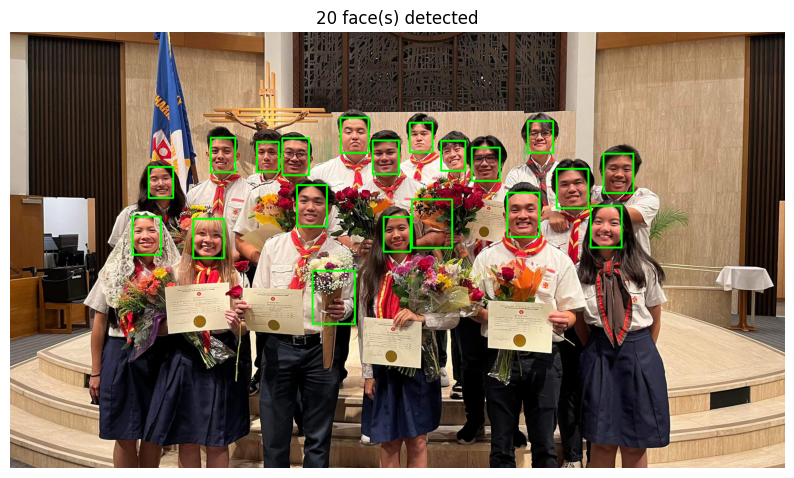

In [79]:
# Detect multiple faces
mtcnn_multi = MTCNN(keep_all=True) # turning mtcnn into detecting multiple faces
boxes, probs, landmarks = mtcnn_multi.detect(img, landmarks=True)

# Draw boxes
import numpy as np
img_boxed = img.copy()

if boxes is not None:
    for box in boxes:
        x1, y1, x2, y2 = [int(b) for b in box]
        cv2.rectangle(img_boxed, (x1, y1), (x2, y2), color=(0,255,0), thickness=4)

# Visualize
plt.figure(figsize=(10, 10))
plt.imshow(img_boxed)
plt.axis('off')
plt.title(f"{len(boxes)} face(s) detected" if boxes is not None else "No faces detected")
plt.show()

In [80]:
# Load image into a tensor
face_tensors = mtcnn_multi(img)

# Face Recognition with Inception Resnet (V1) 
---

In [81]:
mtcnn_single = MTCNN(keep_all=False) # turning mtcnn into detecting only single faces

In [82]:
resnet = InceptionResnetV1(pretrained='vggface2').eval()

In [83]:
# Get 512D embeddings for all faces
# 512D because that is what InceptionResnetV1 is designed to output
embeddings = resnet(face_tensors)  # shape: (N, 512)

In [84]:
def cosine_sim(a, b):
    return torch.nn.functional.cosine_similarity(a.unsqueeze(0), b.unsqueeze(0)).item()

In [86]:
names = [
    "ailyn", "austin", "bdo", "ben", "bignate", "christina",
    "dylan", "jacob", "john", "joseph", "kaitlyn", "kd",
    "marilyn", "peter", "theresa", "trin", "veronica", "will"
]

face_db = {}

for person_name in names:
    img = Image.open(f"images/headshots/{person_name}.jpeg")
    face = mtcnn_single(img)
    if face is not None:
        emb = resnet(face.unsqueeze(0)).detach()
        face_db[person_name] = emb.squeeze(0)